In [183]:
import re
import string
import numpy as np
import chardet
import unicodedata
import random
import os

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization, Input, LSTM, Embedding, Dense, SimpleRNN, TimeDistributed, GRU, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from tensorflow.keras import layers

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split

# Read Data

In [12]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        encoding = result['encoding']
    return encoding

In [13]:
detect_encoding(r'C:\Users\david\DeepLearning\DataSets\Multi_lingual_Parallel_corpus_1\Multilingual_Parllel_corpus.txt')

'utf-8'

In [14]:
# Specify the path to your dataset
org_file_path = r'C:\Users\david\DeepLearning\DataSets\Multi_lingual_Parallel_corpus_1\Multilingual_Parllel_corpus.txt'
languages = {'nl', 'es'}
filtered_texts = []

try:
    with open(org_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(':')
            if len(parts) >= 3 and parts[1] in languages:
                # Append the text portion (all parts after the language code)
                filtered_texts.append(':'.join(parts[2:]))
except FileNotFoundError:
    print("Error: The file does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")



['Voor mij begint dit verhaal ongeveer 15 jaar geleden,', 'Para mí esta historia comienza hace 15 años', "toen ik een hospitaaldokter was aan de 'University of Chicago'.", 'cuando era médico de hospicio en la Universidad de Chicago.', 'Ik zorgde voor stervende mensen en hun families', 'Y cuidaba a gente moribunda y a sus familias', 'in het zuiden van Chicago.', 'en la parte sur de Chicago.', 'Ik observeerde wat er gebeurde met deze mensen en hun families', 'Observaba lo que le sucedía a la gente y a sus familias', 'gedurende het verloop van hun terminale ziekte.', 'en el transcurso de su enfermedad terminal.', 'In mijn lab bestudeerde ik het weduwnaareffect,', 'Y en mi laboratorio yo estudiaba el "efecto viuda"', 'een heel oud begrip in de sociale wetenschappen,', 'que es una idea muy antigua en las ciencias sociales', 'dat 150 jaar terug gaat', 'se remonta a 150 años', "en bekend staat als 'sterven aan een gebroken hart'.", 'es conocida como "morir de corazón partido".', 'Wanneer ik s

## Write filtered data to txt file

In [15]:
output_file_path = r'C:\Users\david\DeepLearning\DataSets\Multi_lingual_Parallel_corpus_1\Filtered_Multilingual_Texts.txt'

try:
    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        for text in filtered_texts:
            output_file.write(text + "\n")
    print("File has been written successfully.")
except Exception as e:
    print(f"An error occurred while writing the file: {e}")

File has been written successfully.


## Pair a dutch text to its corresponding spanish text

In [70]:
# Specify the path to your dataset
filtered_file_path = r'C:\Users\david\DeepLearning\DataSets\Multi_lingual_Parallel_corpus_1\Filtered_Multilingual_Texts.txt'
text_pairs = []

# Check if the file exists before attempting to open it
if not os.path.exists(filtered_file_path):
    print("Error: The file does not exist.")
else:
    try:
        with open(filtered_file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            if len(lines) % 2 != 0:
                print("Warning: Unmatched line in file, the last line will be ignored.")
            
            for i in range(0, len(lines) - 1, 2):
                dutch_text = lines[i].strip()
                spanish_text = "[start] " + lines[i + 1].strip() + " [end]"
                text_pairs.append((dutch_text, spanish_text))
    except Exception as e:
        print(f"An error occurred: {e}")

# Example output of text_pairs
if text_pairs:
    print("Sample text pair:")
    print(random.choice(text_pairs))

Sample text pair:
('anders val ik er straks over.', '[start] porque si no, voy a tropezar con ellos. [end]')


# Preprocessing


## Prepare data for training (tokenization,vectorization and cleaning)

In [189]:
# Configuration
vocab_size = 15000
sequence_length = 20

# Shuffle and split the data
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

# Custom standardization function to preserve specific tokens
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, f"[{re.escape(strip_chars)}]", "")

# Setup TextVectorization
source_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization
)
target_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization
)

# Prepare text data for vectorization
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]

# Adapt vectorization layers to the datasets
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)


## Creating training and validation sets

In [99]:
batch_size = 64

def format_dataset(eng, spa):
     eng = source_vectorization(eng)
     spa = target_vectorization(spa)
     return ({"english": eng, "spanish": spa[:, :-1],}
             , spa[:, 1:])
    
  
def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache() 
    
 
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [100]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")



inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


# Training

## GRU RNN sequence to sequence model


In [126]:
# Configuration settings
embed_dim = 256
latent_dim = 1024
vocab_size = 15000  # Ensure vocab_size is defined as needed

# Define input layers
source = Input(shape=(None,), dtype="int64", name="english")
past_target = Input(shape=(None,), dtype="int64", name="spanish")

# Encoder
x = Embedding(vocab_size, embed_dim, mask_zero=True)(source)

encoded_source = Bidirectional(GRU(latent_dim), merge_mode="sum")(x) 

# Decoder
x = Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)

decoder_gru = GRU(latent_dim, return_sequences=True)

x = decoder_gru(x, initial_state=encoded_source)
x = Dropout(0.5)(x)
target_next_step = Dense(vocab_size, activation="softmax")(x)

# Assemble the full model
seq2seq_rnn = Model(inputs=[source, past_target], outputs=target_next_step)

# Compile the model
seq2seq_rnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Display the model's architecture
seq2seq_rnn.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 english (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 spanish (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_74 (Embedding)       (None, None, 256)    3840000     ['english[0][0]']                
                                                                                                  
 embedding_75 (Embedding)       (None, None, 256)    3840000     ['spanish[0][0]']                
                                                                                           

In [143]:
seq2seq_rnn.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
3818/3818 [==============================] - 237s 62ms/step - loss: 0.6548 - accuracy: 0.6506 - val_loss: 1.4673 - val_accuracy: 0.4869
Epoch 2/30
3818/3818 [==============================] - 241s 63ms/step - loss: 0.6464 - accuracy: 0.6534 - val_loss: 1.4797 - val_accuracy: 0.4856
Epoch 3/30
3818/3818 [==============================] - 238s 62ms/step - loss: 0.6389 - accuracy: 0.6562 - val_loss: 1.4940 - val_accuracy: 0.4852
Epoch 4/30
3818/3818 [==============================] - 237s 62ms/step - loss: 0.6308 - accuracy: 0.6593 - val_loss: 1.5072 - val_accuracy: 0.4834
Epoch 5/30
3818/3818 [==============================] - 237s 62ms/step - loss: 0.6259 - accuracy: 0.6611 - val_loss: 1.5215 - val_accuracy: 0.4834
Epoch 6/30
3818/3818 [==============================] - 237s 62ms/step - loss: 0.6194 - accuracy: 0.6636 - val_loss: 1.5305 - val_accuracy: 0.4824
Epoch 7/30
3818/3818 [==============================] - 238s 62ms/step - loss: 0.6145 - accuracy: 0.6654 - val_loss: 1

## Transformer Model

In [144]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

def layer_normalization(batch_of_sequences):
    mean = np.mean(batch_of_sequences, keepdims=True, axis=-1)
    variance = np.var(batch_of_sequences, keepdims=True, axis=-1)
    return (batch_of_sequences - mean) / np.sqrt(variance + 1e-7)

def batch_normalization(batch_of_images):
    mean = np.mean(batch_of_images, keepdims=True, axis=(0, 1, 2))
    variance = np.var(batch_of_images, keepdims=True, axis=(0, 1, 2))
    return (batch_of_images - mean) / np.sqrt(variance + 1e-7)

In [145]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask if mask is not None else None)
        attention_output_2 = self.layernorm_2(attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [146]:
# Transformer Model Setup
# Configuration settings
embed_dim = 256
dense_dim = 2048
num_heads = 8
sequence_length = 100
vocab_size = 15000

encoder_inputs = Input(shape=(None,), dtype="int64", name="english")
x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x) 

decoder_inputs = Input(shape=(None,), dtype="int64", name="spanish")
x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = Dropout(0.5)(x)
decoder_outputs = Dense(vocab_size, activation="softmax")(x)

transformer = Model([encoder_inputs, decoder_inputs], decoder_outputs)

transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

transformer.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 english (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 spanish (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_85 (Embedding)       (None, None, 256)    3840000     ['english[0][0]']                
                                                                                                  
 embedding_86 (Embedding)       (None, None, 256)    3840000     ['spanish[0][0]']                
                                                                                           

In [147]:
transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
3818/3818 [==============================] - 202s 52ms/step - loss: 2.2552 - accuracy: 0.6795 - val_loss: 2.0589 - val_accuracy: 0.6944
Epoch 2/30
3818/3818 [==============================] - 198s 52ms/step - loss: 2.0734 - accuracy: 0.6993 - val_loss: 1.9515 - val_accuracy: 0.7071
Epoch 3/30
3818/3818 [==============================] - 198s 52ms/step - loss: 1.9884 - accuracy: 0.7090 - val_loss: 1.9245 - val_accuracy: 0.7152
Epoch 4/30
3818/3818 [==============================] - 196s 51ms/step - loss: 1.9818 - accuracy: 0.7184 - val_loss: 1.9268 - val_accuracy: 0.7233
Epoch 5/30
3818/3818 [==============================] - 197s 52ms/step - loss: 1.9559 - accuracy: 0.7260 - val_loss: 1.9221 - val_accuracy: 0.7254
Epoch 6/30
3818/3818 [==============================] - 197s 52ms/step - loss: 1.9331 - accuracy: 0.7315 - val_loss: 1.9027 - val_accuracy: 0.7299
Epoch 7/30
3818/3818 [==============================] - 200s 52ms/step - loss: 1.9114 - accuracy: 0.7360 - val_loss: 1

In [162]:
seq2seq_rnn.save('rnn.h5')
transformer.save('transformer.h5')

In [171]:
train_loss = [0.6548, 0.6464, 0.6389, 0.6308, 0.6259, 0.6194, 0.6145, 0.6102, 0.6067, 0.6037, 
              0.6007, 0.5976, 0.5939, 0.5917, 0.5902, 0.5880, 0.5857, 0.5834, 0.5832, 0.5819, 
              0.5814, 0.5793, 0.5791, 0.5783, 0.5770, 0.5768, 0.5757, 0.5758, 0.5755, 0.5748]
val_loss = [1.4673, 1.4797, 1.4940, 1.5072, 1.5215, 1.5305, 1.5397, 1.5441, 1.5534, 1.5559, 
            1.5710, 1.5781, 1.5761, 1.5935, 1.5916, 1.5939, 1.5969, 1.5960, 1.6109, 1.6136, 
            1.6129, 1.6261, 1.6290, 1.6203, 1.6365, 1.6363, 1.6439, 1.6438, 1.6497, 1.6458]
train_accuracy = [0.6506, 0.6534, 0.6562, 0.6593, 0.6611, 0.6636, 0.6654, 0.6672, 0.6680, 0.6693, 
                  0.6703, 0.6717, 0.6731, 0.6741, 0.6748, 0.6757, 0.6766, 0.6778, 0.6776, 0.6778, 
                  0.6781, 0.6789, 0.6791, 0.6796, 0.6800, 0.6799, 0.6805, 0.6804, 0.6806, 0.6807]
val_accuracy = [0.4869, 0.4856, 0.4852, 0.4834, 0.4834, 0.4824, 0.4824, 0.4814, 0.4805, 0.4792, 
                0.4802, 0.4796, 0.4800, 0.4787, 0.4785, 0.4772, 0.4779, 0.4771, 0.4768, 0.4776, 
                0.4760, 0.4774, 0.4760, 0.4755, 0.4745, 0.4737, 0.4753, 0.4753, 0.4743, 0.4735]

# Epochs array
epochs = range(1, 31)

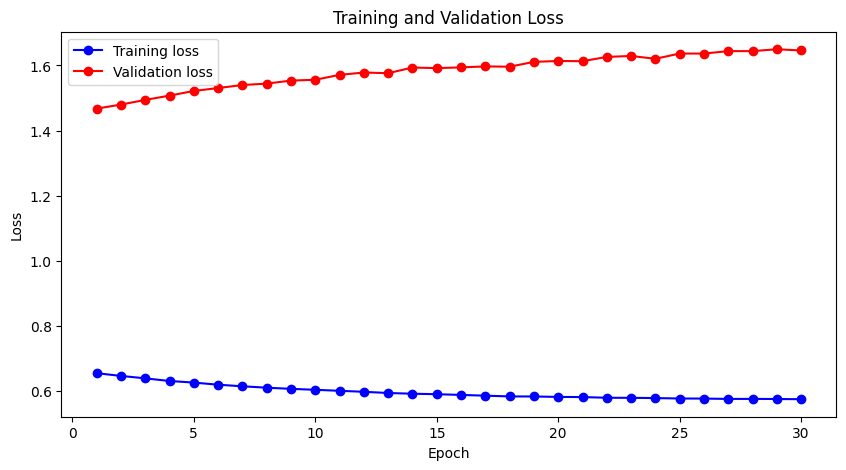

Text(0.5, 0, 'Epoch')

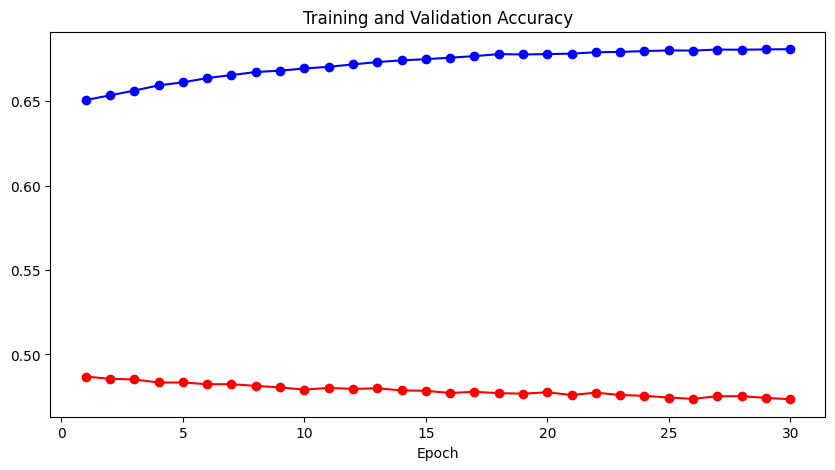

In [173]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')


In [174]:
# Manually record the losses and accuracies
train_loss = [2.2552, 2.0734, 1.9884, 1.9818, 1.9559, 1.9331, 1.9114, 1.8933, 1.8756, 1.8574, 
              1.8408, 1.8261, 1.8152, 1.8064, 1.7943, 1.7818, 1.7708, 1.7612, 1.7552, 1.7516, 
              1.7427, 1.7303, 1.7190, 1.7088, 1.7008, 1.6974, 1.6894, 1.6804, 1.6733, 1.6640]
val_loss = [2.0589, 1.9515, 1.9245, 1.9268, 1.9221, 1.9027, 1.8853, 1.8867, 1.8779, 1.8707, 
            1.8692, 1.8666, 1.8742, 1.8799, 1.8783, 1.8769, 1.8869, 1.8824, 1.8858, 1.8966, 
            1.9186, 1.9093, 1.9199, 1.9161, 1.9203, 1.9451, 1.9302, 1.9325, 1.9487, 1.9325]
train_accuracy = [0.6795, 0.6993, 0.7090, 0.7184, 0.7260, 0.7315, 0.7360, 0.7397, 0.7429, 0.7460, 
                  0.7486, 0.7511, 0.7532, 0.7553, 0.7571, 0.7588, 0.7605, 0.7619, 0.7631, 0.7646, 
                  0.7660, 0.7678, 0.7694, 0.7707, 0.7724, 0.7736, 0.7748, 0.7759, 0.7773, 0.7783]
val_accuracy = [0.6944, 0.7071, 0.7152, 0.7233, 0.7254, 0.7299, 0.7322, 0.7332, 0.7343, 0.7352, 
                0.7354, 0.7355, 0.7339, 0.7367, 0.7342, 0.7353, 0.7302, 0.7355, 0.7321, 0.7341, 
                0.7349, 0.7340, 0.7271, 0.7326, 0.7339, 0.7333, 0.7317, 0.7307, 0.7322, 0.7319]

# Epochs array
epochs = range(1, 31)

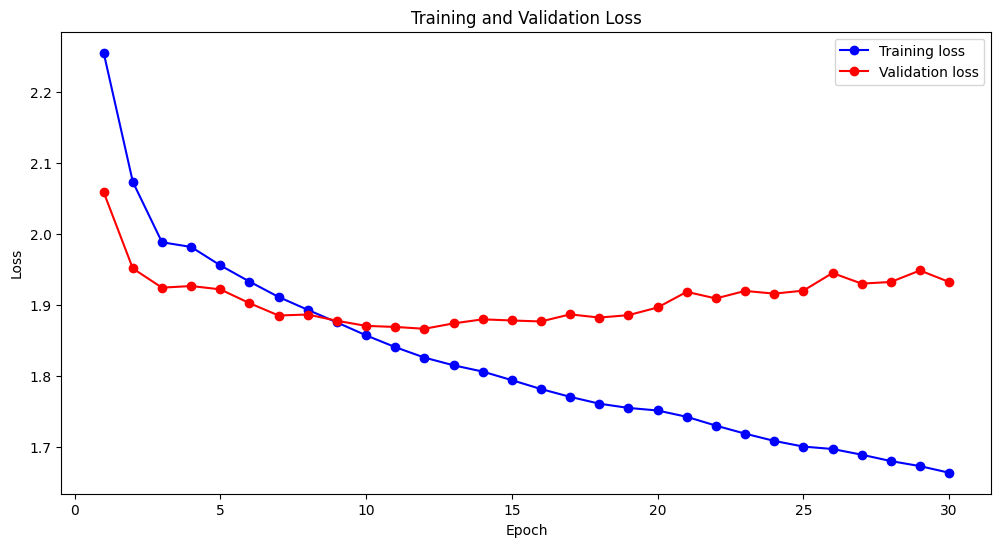

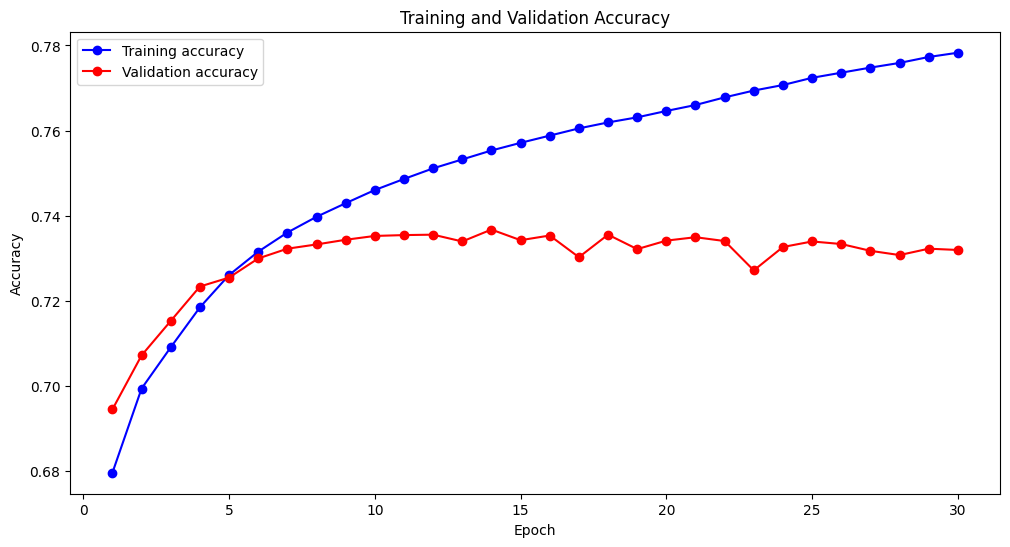

In [175]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'b-o', label='Training loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, 'b-o', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r-o', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluation

In [180]:
dutch_sentences = [
    "Hij loopt elke ochtend langs het kanaal.",
    "De kat sprong op de tafel toen niemand keek.",
    "Kun je me vertellen hoe laat het is?",
    "Ze heeft een boek over de geschiedenis van Amsterdam gekocht.",
    "We gaan volgende week naar een concert in het park.",
    "De lucht is erg bewolkt vandaag, het zal waarschijnlijk regenen.",
    "Kan ik een kopje koffie bestellen, alstublieft?",
    "Mijn broer woont in Den Haag en werkt in Rotterdam.",
    "Zij spreekt vier talen vloeiend: Nederlands, Engels, Frans en Duits.",
    "De kinderen spelen buiten terwijl hun ouders het diner voorbereiden."
]

spanish_translation = [
    "Camina por el canal todas las mañanas.",
    "El gato saltó sobre la mesa cuando nadie miraba.",
    "¿Puedes decirme qué hora es?",
    "Compró un libro sobre la historia de Ámsterdam.",
    "Vamos a ir a un concierto en el parque la semana que viene.",
    "El cielo está muy nublado hoy, probablemente lloverá.",
    "¿Puedo pedir una taza de café, por favor?",
    "Mi hermano vive en La Haya y trabaja en Rotterdam.",
    "Habla cuatro idiomas con fluidez: holandés, inglés, francés e Alemán.",
    "Los niños juegan afuera mientras sus padres preparan la cena."]

In [181]:
# Prepare a dictionary to convert token index predictions to string tokens.
spa_vocab = target_vectorization.get_vocabulary() 
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab)) 
max_decoded_sentence_length = 20

def decode_sequence_rnn(input_sentence):
    # Tokenize the input sentence.
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    
    # Generate each token for the sentence using the RNN model.
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

def decode_sequence_transformer(input_sentence):
    # Tokenize the input sentence.
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"

    # Generate each token for the sentence using the transformer model.
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

In [182]:
for sentence in dutch_sentences:
    print("-")
    print("Dutch:", sentence)
    print("Spanish (RNN):", decode_sequence_rnn(sentence))
    print("Spanish (Transformer):", decode_sequence_transformer(sentence))

-
Dutch: Hij loopt elke ochtend langs het kanaal.
1/1 [==============================] - 0s 110ms/step
Spanish (RNN): [start] y se [UNK] cada mañana en el canal [end]
Spanish (Transformer): [start] está [UNK] cada mañana [end]
-
Dutch: De kat sprong op de tafel toen niemand keek.
1/1 [==============================] - 0s 83ms/step
Spanish (RNN): [start] el gato [UNK] en la mesa como en la escuela [end]
Spanish (Transformer): [start] y nadie lo [UNK] la mesa del [UNK] [end]
-
Dutch: Kun je me vertellen hoe laat het is?
1/1 [==============================] - 0s 70ms/step
Spanish (RNN): [start] puedes [UNK] cómo es [end]
Spanish (Transformer): [start] y te [UNK] y me [UNK] [end]
-
Dutch: Ze heeft een boek over de geschiedenis van Amsterdam gekocht.
1/1 [==============================] - 0s 72ms/step
Spanish (RNN): [start] ella es un libro de la historia de la universidad de [UNK] [end]
Spanish (Transformer): [start] uno de los [UNK] tiene un libro de [UNK] [end]
-
Dutch: We gaan volgende 

In [186]:
# Translate sentences using both models and calculate BLEU scores.
for idx, sentence in enumerate(dutch_sentences):
    print("-")
    print("Dutch:", sentence)
    
    translated_rnn = decode_sequence_rnn(sentence)
    translated_transformer = decode_sequence_transformer(sentence)
    
    reference = [spanish_translation[idx].split()]  # Reference translations must be tokenized and in a list
    candidate_rnn = translated_rnn.split()
    candidate_transformer = translated_transformer.split()
    
    bleu_score_rnn = sentence_bleu(reference, candidate_rnn)
    bleu_score_transformer = sentence_bleu(reference, candidate_transformer)
    
    print("Spanish (RNN):", translated_rnn)
    print("BLEU Score (RNN):", bleu_score_rnn)
    print("Spanish (Transformer):",translated_transformer)
    print("BlEU Score (Transformer)",bleu_score_transformer)

-
Dutch: Hij loopt elke ochtend langs het kanaal.
1/1 [==============================] - 0s 61ms/step
Spanish (RNN): [start] y se [UNK] cada mañana en el canal [end]
BLEU Score (RNN): 5.7592918561109494e-155
Spanish (Transformer): [start] está [UNK] cada mañana [end]
BlEU Score (Transformer) 0
-
Dutch: De kat sprong op de tafel toen niemand keek.
1/1 [==============================] - 0s 57ms/step
Spanish (RNN): [start] el gato [UNK] en la mesa como en la escuela [end]
BLEU Score (RNN): 5.791739854583281e-155
Spanish (Transformer): [start] y nadie lo [UNK] la mesa del [UNK] [end]
BlEU Score (Transformer) 6.373704167435469e-155
-
Dutch: Kun je me vertellen hoe laat het is?
1/1 [==============================] - 0s 55ms/step
Spanish (RNN): [start] puedes [UNK] cómo es [end]
BLEU Score (RNN): 0
Spanish (Transformer): [start] y te [UNK] y me [UNK] [end]
BlEU Score (Transformer) 0
-
Dutch: Ze heeft een boek over de geschiedenis van Amsterdam gekocht.
1/1 [==============================] - 0

C:\Program Files\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 [==============================] - 0s 59ms/step
Spanish (RNN): [start] tal vez [UNK] por un café de [UNK] [end]
BLEU Score (RNN): 1.2183324802375697e-231
Spanish (Transformer): [start] y puedo [UNK] una [end]
BlEU Score (Transformer) 8.34076112986429e-232
-
Dutch: Mijn broer woont in Den Haag en werkt in Rotterdam.
1/1 [==============================] - 0s 57ms/step
Spanish (RNN): [start] mi hermano en [UNK] en el [UNK] [end]
BLEU Score (RNN): 1.2387197655613557e-231
Spanish (Transformer): [start] y mi [UNK] en [UNK] [UNK] mi [UNK] [end]
BlEU Score (Transformer) 1.2183324802375697e-231
-
Dutch: Zij spreekt vier talen vloeiend: Nederlands, Engels, Frans en Duits.
1/1 [==============================] - 0s 90ms/step
Spanish (RNN): [start] ella dice [UNK] idiomas simultáneamente [end]
BLEU Score (RNN): 7.296382734947757e-232
Spanish (Transformer): [start] [UNK] [UNK] y [UNK] [UNK] [UNK] [UNK] [UNK] cinco [end]
BlEU Score (Transformer) 0
-
Dutch: De kinderen spelen buiten terwijl hun ou